In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [2]:
spark = SparkSession \
    .builder \
    .appName("Learning Spark") \
    .getOrCreate()

In [3]:
df = spark.read.json("harvester/claims/*jsonl")

In [4]:
df.count()

522

In [5]:
df = df.where("version = '0.0.2'")
#df.sort("scraped_at").show(df.count())

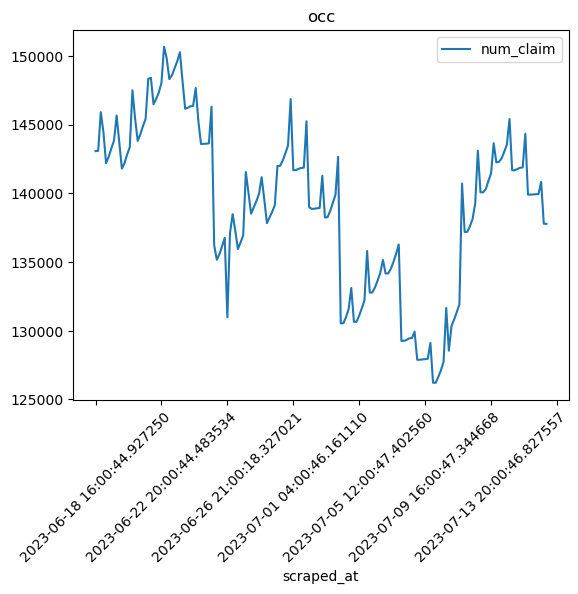

In [6]:
data = df.where(df.url.startswith("https://www.occ")).sort("scraped_at").withColumn("num_claim", df["claim"].cast("int")).toPandas()
data.plot("scraped_at", "num_claim")
plt.title("occ")
_ = plt.xticks(rotation=45)

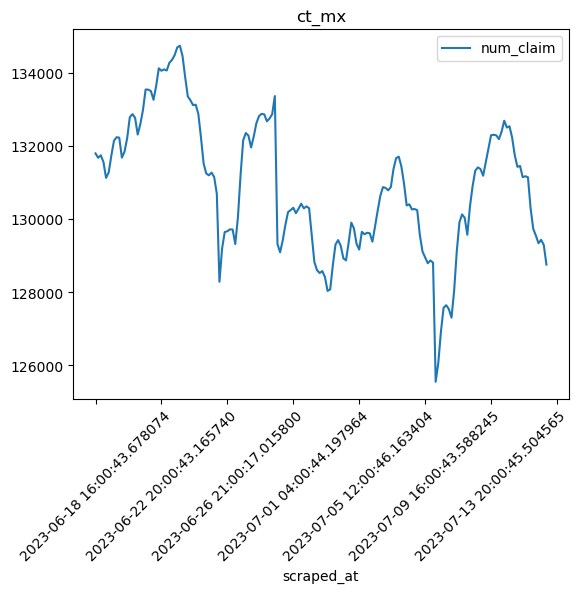

In [7]:
data = df.where(df.url.startswith("https://mx.computrabajo")).sort("scraped_at").withColumn("num_claim", df["claim"].cast("int")).toPandas()
data.plot("scraped_at", "num_claim")
plt.title("ct_mx")
_ = plt.xticks(rotation=45)

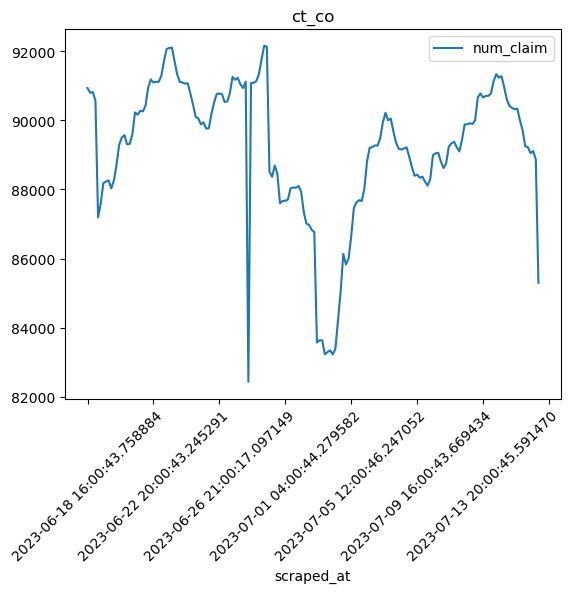

In [8]:
data = df.where(df.url.startswith("https://co.computrabajo")).sort("scraped_at").withColumn("num_claim", df["claim"].cast("int")).toPandas()
data.plot("scraped_at", "num_claim")
plt.title("ct_co")
_ = plt.xticks(rotation=45)

In [9]:
spark.sparkContext.defaultParallelism

4

In [10]:
df.rdd.getNumPartitions()

6

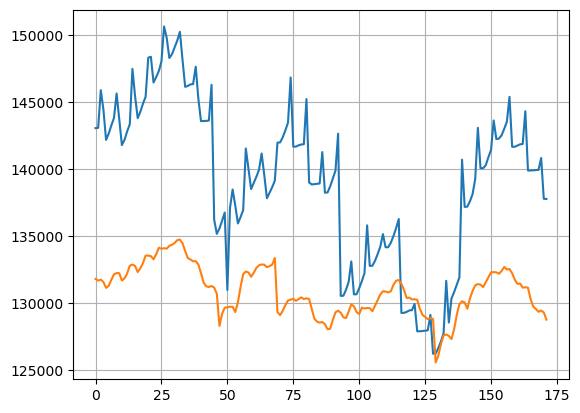

In [11]:
ct = df.where(df.url.startswith("https://mx.computrabajo")).sort("scraped_at").withColumn("num_claim", df["claim"].cast("int")).select("scraped_at", "num_claim").toPandas()
occ = df.where(df.url.startswith("https://www.occ")).sort("scraped_at").withColumn("num_claim", df["claim"].cast("int")).select("scraped_at", "num_claim").toPandas()

plt.plot(occ["num_claim"])
plt.plot(ct["num_claim"])
plt.grid(which="both")
plt.show()

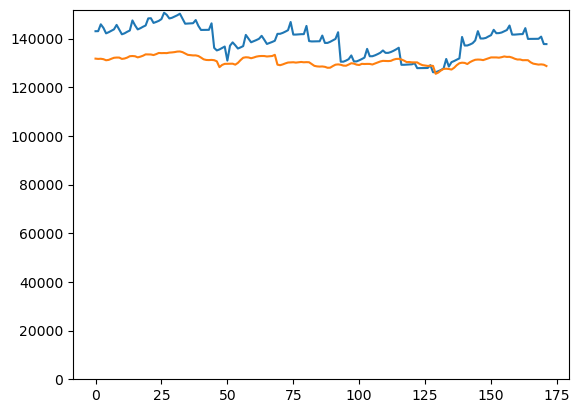

In [12]:
plt.plot(occ["num_claim"])
plt.plot(ct["num_claim"])
plt.ylim(bottom=0)
plt.show()